# Multithreading

In the previous example, csound was executed by calling `.performKsmps` directly, within a loop. To use Csound in a more flexible way it is advisable to run the performance loop in a dedicated thread

Cound has a helper class called CsoundPerformanceThread, which creates a native thread and runs the performance loop of an existing csound instance on that thread. The main Python thread is thus not blocked, allowing the user to interract with it, while the performance thread runs concurrently, outside of the GIL. The user can send messages to the performance thread to toggle pause, schedule input evets, etc.

### Example


In [1]:
import libcsound
cs = libcsound.Csound()
cs.setOption('-d -odac -m0')
cs.compileOrc(r'''
sr     = 48000
ksmps  = 64
nchnls = 2
0dbfs  = 1

instr 1
  iamp, ipitch, iattack, idec, ipan passign 4
  aenv = linen:a(1, iattack, p3, idec)
  asig = poscil(iamp, mtof(ipitch)) * aenv
  a1, a2 pan2 asig, ipan
  outs a1, a2
endin
''')


0

This creates a new thread with the existing csound process

In [2]:
thread = cs.performanceThread()
thread.play()

--Csound version 7.0 (double samples) Jan  3 2025
[commit: 7e3505c5d43b0d433091bc5e9ca973162cc35ce4]
libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
writing 512 sample blks of 64-bit floats to dac
SECTION 1:


Now, we can send messages to the performance thread:

In [3]:
thread.scoreEvent(False, 'i', (1, 0,   1, 0.5, 60, 0.05, 0.3, 0.2))
thread.scoreEvent(False, 'i', (1, 0.5, 1, 0.5, 62, 0.05, 0.3, 0.8))

When we're done, we stop the performance thread:

In [4]:
thread.stop()
thread.join()
del cs

		   overall amps:  0.62995  0.62998
	   overall samples out of range:        0        0
0 errors in performance
571 512 sample blks of 64-bit floats written to dac


The previous example can be reproduced using a performance thread:

In [5]:
cs = libcsound.Csound()

# Change as needed
# cs.setOption('-odac')
cs.setOption('-+rtaudio=jack -odac:Built-in' )

# Disable printing whenever a new event is scheduled
cs.setOption('-m128')

# The orchestra
cs.compileOrc(r'''
sr = 48000
nchnls = 2
ksmps = 64
0dbfs = 1

instr 1
  iamp = p4
  ipitch = p5
  iattack = p6 
  irelease = p7 
  a0 = oscili(iamp, mtof(ipitch)) + oscili(iamp, mtof(ipitch+0.12))
  outall a0 * linsegr:a(0, iattack, 1, iattack*2, 0.2, irelease, 0)
endin
''')

thread = cs.performanceThread()
thread.play()


rtaudio: JACK module enabled
--Csound version 7.0 (double samples) Jan  3 2025
[commit: 7e3505c5d43b0d433091bc5e9ca973162cc35ce4]
libsndfile-1.2.2
graphics suppressed, ascii substituted
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
orch now loaded
audio buffered in 256 sample-frame blocks
system sr: 48000.000000
Jack output ports:
 0: dac0 (dac:Built-in Audio Analog Stereo:playback_FL)
 1: dac1 (dac:Built-in Audio Analog Stereo:playback_FR)
connecting channel 0 to Built-in Audio Analog Stereo:playback_FL
connecting channel 1 to Built-in Audio Analog Stereo:playback_FR
writing 512 sample blks of 64-bit floats to dac:Built-in
SECTION 1:


In [12]:
import random
import time

scale = [0, 2, 4, 5, 7, 9, 11]
pitches = [60 + 12 * octave + step for octave in [0, 1, 2] for step in scale]
chords = [(2, 4, 7), (4, 5), (2, 7, 11), (0, 5, 9), (9, 11), (0, 2), (0, 4, 7)]
chord = random.choice(chords)

def getparams(pitch, chord):
    if pitch % 12 in chord:
        dur = random.uniform(1.5, 2.5)
        amp = random.uniform(0.04, 0.2)
        att = random.uniform(0.01, 0.1)
        rel = random.uniform(0.4, 0.8)
    else:
        dur = random.uniform(0.1, 0.2)
        amp = random.uniform(0.04, 0.08)
        att = 0.01
        rel = 0.3
    return dur, amp, att, rel
        
sr = cs.sr()
t0 = tchord = tstart = cs.currentTimeSamples() / sr

# Record output to be able to embed it in the notebook
thread.record("threading-example1.wav", 16, 2)

while True:
    t = cs.currentTimeSamples() / sr
    # Break after 30 seconds
    if t - tstart > 30:
        break
    if t - t0 > 1/8.:
        pitch = random.choice(pitches)
        dur, amp, att, rel = getparams(pitch, chord)
        thread.scoreEvent(False, 'i', (1, 0, dur, amp, random.choice(pitches), att, rel))
        t0 = t
        time.sleep(1/16.)
        if t - tchord > 8:
            chord = random.choice(chords)
            tchord = t        
    else:
        time.sleep(1/64.)

thread.stopRecord()


    

Perf thread: stopped recording,
closing file threading-example1.wav


In [ ]:
%pip install matplotlib sndfileio

In [9]:
def sndconvert(path, fmt):
    import os
    import sndfileio
    
    outfile = os.path.splitext(path)[0] + fmt
    samples, sr = sndfileio.sndread(path)
    sndfileio.sndwrite(outfile, samples, sr)
    os.remove(path)


In [ ]:
sndconvert("threading-example1.wav", ".mp3")

In [17]:
import IPython
IPython.display.Audio("threading-example1.mp3")

## Process Callback

The performance thread includes a mechanism to register a python callback, which will be fired at each performance cycle. Within this callback python has access to the csound instance without locks. This solves the problem of added latency to access the csound API whenever a performance thread is used.

In [1]:
import queue
import time
import random
import libcsound

In [2]:
cs = libcsound.Csound()

# Change as needed
# cs.setOption('-odac')
cs.setOption('-+rtaudio=jack -odac:Built-in' )

# Disable printing whenever a new event is scheduled
cs.setOption('-m128')

# The orchestra
cs.compileOrc(r'''
sr = 48000
nchnls = 2
ksmps = 64
0dbfs = 1

instr 1
  iamp, ipitch, iattack, irelease passign 4
  a0 = oscili(iamp, mtof(ipitch)) + oscili(iamp, mtof(ipitch+0.12))
  outall a0 * linsegr:a(0, iattack, 1, iattack*2, 0.2, irelease, 0)
endin
''')

thread = cs.performanceThread()
thread.play()


# This is basically the same as the example before
scale = [0, 2, 3, 5, 7, 8, 10]
pitches = [60 + 12 * octave + step for octave in [0, 1, 2] for step in scale]
chords = [(2, 4, 7), (4, 5), (2, 7, 11), (0, 5, 9), (9, 11), (0, 2), (0, 4, 7)]

def getparams(pitch, chord):
    if pitch % 12 in chord:
        dur = random.uniform(1.5, 2.5)
        amp = random.uniform(0.04, 0.2)
        att = random.uniform(0.01, 0.1)
        rel = random.uniform(0.4, 0.8)
    else:
        dur = random.uniform(0.1, 0.2)
        amp = random.uniform(0.04, 0.08)
        att = 0.01
        rel = 0.3
    return dur, amp, att, rel

sr = cs.sr()

# We create a callback class in order to hold state between calls
class Callback:
    def __init__(self):
        self.t0 = cs.currentTimeSamples() / sr
        self.tchord = self.t0
        self.chord = random.choice(chords)

    # This method will be called every time csound process a block
    # of samples, with full access to the API
    # Notice that we do not need to call .sleep
    def __call__(self, data):
        t = cs.currentTimeSamples() / sr
        if t - self.t0 > 1/8.:
            pitch = random.choice(pitches)
            dur, amp, att, rel = getparams(pitch, self.chord)
            thread.scoreEvent(False, 'i', (1, 0, dur, amp, random.choice(pitches), att, rel))
            self.t0 = t
            if t - self.tchord > 8:
                self.chord = random.choice(chords)
                self.tchord = t   

thread.record("threading-example2.wav", 16, 1)
thread.setProcessCallback(Callback())

rtaudio: JACK module enabled
--Csound version 7.0 (double samples) Jan  3 2025
[commit: 7e3505c5d43b0d433091bc5e9ca973162cc35ce4]
libsndfile-1.2.2
graphics suppressed, ascii substituted
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
orch now loaded
audio buffered in 256 sample-frame blocks
system sr: 48000.000000
Jack output ports:
 0: dac0 (dac:Built-in Audio Analog Stereo:playback_FL)
 1: dac1 (dac:Built-in Audio Analog Stereo:playback_FR)
connecting channel 0 to Built-in Audio Analog Stereo:playback_FL
connecting channel 1 to Built-in Audio Analog Stereo:playback_FR
writing 512 sample blks of 64-bit floats to dac:Built-in
SECTION 1:


In [3]:
thread.stopRecord()

Perf thread: stopped recording,
closing file threading-example2.wav


In [4]:
thread.stop()
thread.join()


inactive allocs returned to freespace
		   overall amps:  0.54120  0.54120
	   overall samples out of range:        0        0
0 errors in performance
Elapsed time at end of performance: real: 32.593s, CPU: 5.029s
6106 512 sample blks of 64-bit floats written to dac:Built-in


In [10]:
sndconvert("threading-example2.wav", ".mp3")

In [13]:
import IPython
IPython.display.Audio("threading-example2.mp3")

## Process Queue

For convenience the performance thread implements an optional built-in process queue, using the process callback, similar to the example before. When the process queue is set up, it is possible to schedule tasks (callbacks) which are run within the performance loop with full access to the API. Without this, access to the API is possible but can result in erratic latency, since such operations block until the performance thread yields.

To schedule a task to be run at the next performance cycle the performance thread has a `task` method, which is called with a function expecting the csound object as its first argument. 


In [6]:
import libcsound
import time

cs = libcsound.Csound()

# Modify as needed
# cs.setOption('-odac')
cs.setOption('-+rtaudio=jack -odac:Built-in -B512 -b256')

cs.compileOrc(r'''
sr     = 48000
ksmps  = 64
nchnls = 2
0dbfs  = 1

instr 1
  ipitch = p4
  asig = poscil(0.8, mtof(ipitch)) 
  outch 1, asig * linsegr:a(1, 0.2, 0.2, 0.1, 0)
endin
''')

# We create the performance thread with a process queue
thread = cs.performanceThread(withProcessQueue=True)
thread.play()

# When using a performance thread it is possible to both output to dac and
# record the audio at the same time
thread.record('with-queue.flac', samplebits=24, numbufs=1)

thread.scoreEvent(0, 'i', (1, 0, 0.5, 72))

# Compilation always happens within one cycle. By performing the compilation within the
# process callback we ensure that the new instrument is ready to be scheduled by the 
# performance thread right away. The previous scheduled event (instr 1) and the 
# scheduled event after the compilation (instr 10) should be in sync

thread.task(lambda cs: cs.compileOrc(r'''
instr 10
  ifreq = p4
  outch 2, vco2:a(0.6, ifreq) * linsegr:a(1, 0.2, 0.2, 0.1, 0)
endin
'''))

thread.scoreEvent(0, 'i', (10, 0, 0.5, 600))

time.sleep(1)
thread.stopRecord()
cs.stop()


rtaudio: JACK module enabled
--Csound version 7.0 (double samples) Jan  3 2025
[commit: 7e3505c5d43b0d433091bc5e9ca973162cc35ce4]
libsndfile-1.2.2
graphics suppressed, ascii substituted
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
orch now loaded
audio buffered in 256 sample-frame blocks
system sr: 48000.000000
Jack output ports:
 0: dac0 (dac:Built-in Audio Analog Stereo:playback_FL)
 1: dac1 (dac:Built-in Audio Analog Stereo:playback_FR)
connecting channel 0 to Built-in Audio Analog Stereo:playback_FL
connecting channel 1 to Built-in Audio Analog Stereo:playback_FR
writing 512 sample blks of 64-bit floats to dac:Built-in
SECTION 1:
	   T  0.016 TT  0.016 M:  0.00000  0.00000
new alloc for instr 1:
	   T  0.017 TT  0.017 M:  0.79846  0.00000
new alloc for instr 10:
Perf thread: stopped recording,
closing file with-queue.flac
inactive allocs returned to freespace
		   overall amps:  0.79846  0.69166
	   overall samples out of range:        0        0
0 er

To demonstrate the effect of using a process queue we can plot the generated soundfile. 

For that we need first some extra packages which might not be installed in the system

In [ ]:
%pip install matplotlib sndfileio
import sndfileio

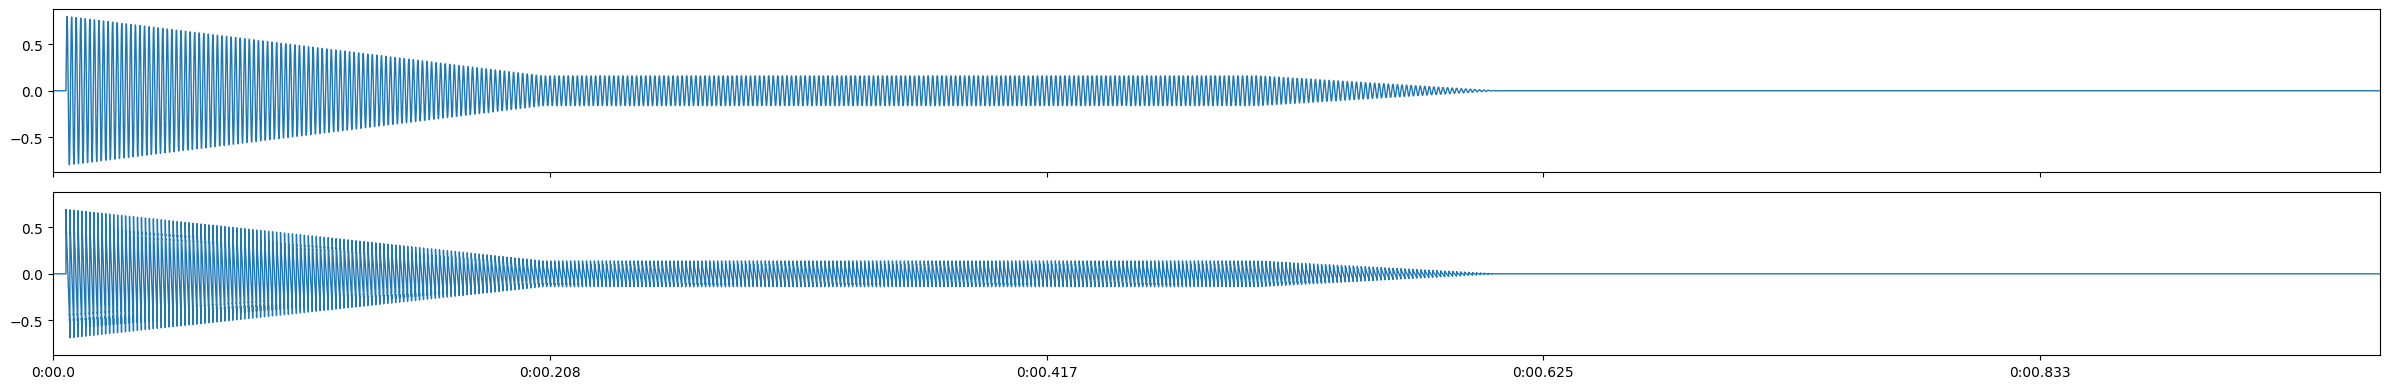

In [5]:
samples, sr = sndfileio.sndread("with-queue.flac")
fig = libcsound._util.waveplot(samples, sr)


For comparison it is possible to try the same without a process queue. The events should be slightly out of sync now

In [31]:
import libcsound
import time

cs = libcsound.Csound()

# Modify as needed
# cs.setOption('-odac')
cs.setOption('-+rtaudio=jack -odac:Built-in -B512 -b256' )

cs.compileOrc(r'''
sr     = 48000
ksmps  = 64
nchnls = 2
0dbfs  = 1

instr 1
  ipitch = p4
  asig = poscil(0.8, mtof(ipitch)) 
  outch 1, asig * linsegr:a(1, 0.2, 0.2, 0.1, 0)
endin
''')

# We create the performance thread without a process queue
thread = cs.performanceThread()
thread.play()
thread.record('no-queue.flac', samplebits=24, numbufs=1)

thread.scoreEvent(0, 'i', (1, 0, 0.5, 72))

# The delay in compilation might take some time now, since the performance thread and the
# csound instance might fight for the API lock

cs.compileOrc(r'''
instr 10
  ifreq = p4
  outch 2, vco2:a(0.6, ifreq) * linsegr:a(1, 0.2, 0.2, 0.1, 0)
endin
''')

thread.scoreEvent(0, 'i', (10, 0, 0.5, 600))

time.sleep(1)
thread.stopRecord()
cs.stop()


rtaudio: JACK module enabled
--Csound version 7.0 (double samples) Dec  4 2024
[commit: ababd1a5e09ada51e5013f24732265a4273f9f09]
libsndfile-1.2.2
graphics suppressed, ascii substituted
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
orch now loaded
audio buffered in 256 sample-frame blocks
system sr: 48000.000000
Jack output ports:
 0: dac0 (dac:I53:playback_FL)
 1: dac1 (dac:I53:playback_FR)
 2: dac2 (dac:Built-in Audio Analog Stereo:playback_FL)
 3: dac3 (dac:Built-in Audio Analog Stereo:playback_FR)
connecting channel 0 to Built-in Audio Analog Stereo:playback_FL
connecting channel 1 to Built-in Audio Analog Stereo:playback_FR
writing 512 sample blks of 64-bit floats to dac:Built-in
SECTION 1:
	   T  0.032 TT  0.032 M:  0.00000  0.00000
new alloc for instr 1:
	   T  0.059 TT  0.059 M:  0.79846  0.00000
new alloc for instr 10:
Perf thread: stopped recording,
closing file no-queue.flac
inactive allocs returned to freespace
		   overall amps:  0.79846  0.69

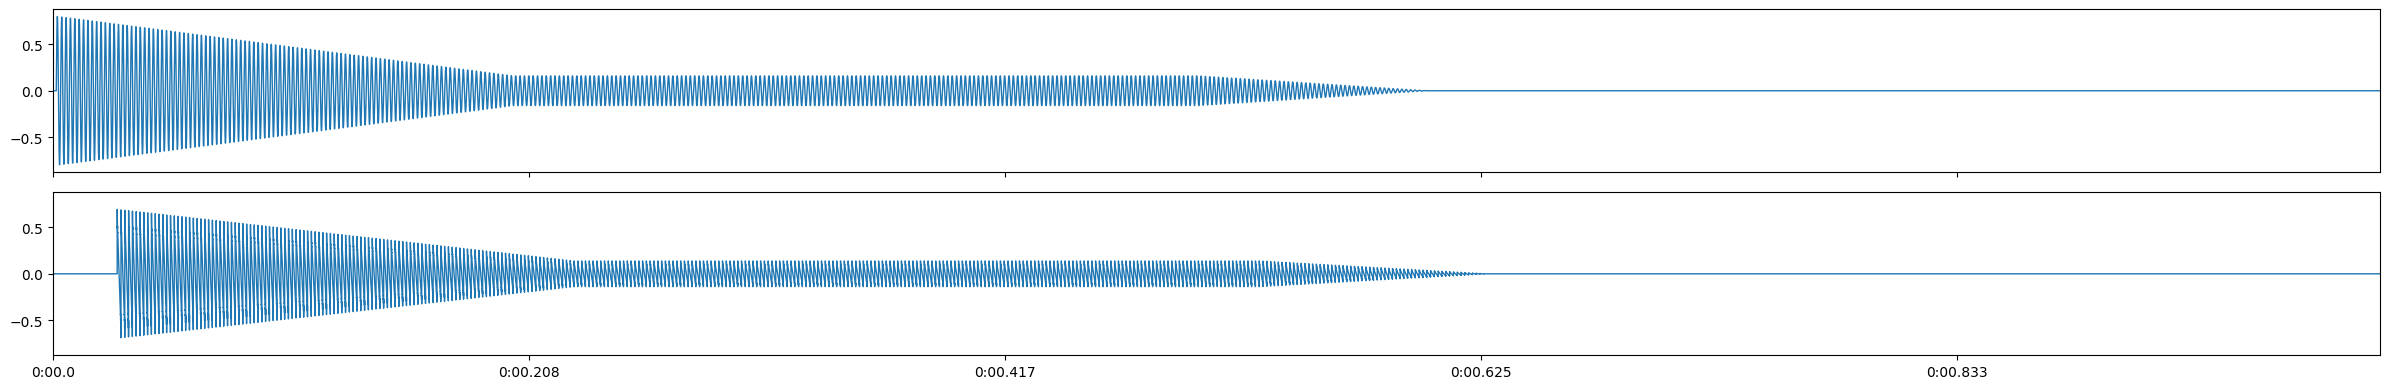

In [32]:
samples, sr = sndfileio.sndread("no-queue.flac")
fig = libcsound._util.waveplot(samples, sr)

## Interacting with the API with a performance thread

The simplest way to interact with a running csound process is via channels or tables. In both cases the API can return a pointer, which is seen from python as a numpy array with shared memory between python and csound. Any modification of that array will be seen by csound and vice-versa.

In the following example we create a channel specific to an event in order to control the frequency. This is a somewhat artificial example to show the flexibility of csound's API

In [1]:
import libcsound
import time
import queue

cs = libcsound.Csound()
cs.setOption("-+rtaudio=jack -odac:Built-in -B512 -b256")
cs.compileOrc(r'''
sr = 48000
ksmps = 64
0dbfs = 1
nchnls = 2

instr 1
  i_id = p4
  Schan = sprintf("kfreq:%d", i_id)
  kfreq = chnget:k(Schan)
  asig = vco2(0.1, lag:k(kfreq, 0.1))
  outch 1, asig
endin
''')

thread = cs.performanceThread(withProcessQueue=True)
thread.play()

# This function launches an instance of instr 1
def launch1(noteid, freq, t=0, dur=10):
    # A queue to receive the channel pointer once the instance is launched
    q = queue.SimpleQueue()

    # The actual callback
    def task(cs):
        # Create a channel specific to this instance
        arr, err = cs.channelPtr(f"kfreq:{noteid}", "control")
        arr[0] = freq
        # Launch the actual instance with the given note id
        thread.scoreEvent(0, 'i', (1, t, dur, noteid))
        # Put the channel pointer in the queue, this notifies the main thread that we are done
        q.put(arr)
    # Launch a process task
    thread.task(task)
    # Wait for the task to finish, this returns the channel pointer
    return q.get()

# Launch 2 events with ids 1 and 2
score = {1: (0, 10, 800), 
         2: (1, 10, 810)}
channels = {eventid: launch1(eventid, freq=data[2], t=data[0], dur=data[1]) for eventid, data in score.items()}

time.sleep(2)
# Modify the freq. of event 1
channels[1][0] = 600

time.sleep(3)
cs.stop()

rtaudio: JACK module enabled
--Csound version 7.0 (double samples) Dec  4 2024
[commit: ababd1a5e09ada51e5013f24732265a4273f9f09]
libsndfile-1.2.2
graphics suppressed, ascii substituted
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
orch now loaded
audio buffered in 256 sample-frame blocks
system sr: 48000.000000
Jack output ports:
 0: dac0 (dac:Built-in Audio Analog Stereo:playback_FL)
 1: dac1 (dac:Built-in Audio Analog Stereo:playback_FR)
connecting channel 0 to Built-in Audio Analog Stereo:playback_FL
connecting channel 1 to Built-in Audio Analog Stereo:playback_FR
writing 512 sample blks of 64-bit floats to dac:Built-in
SECTION 1:
	   T  0.001 TT  0.001 M:  0.00000  0.00000
new alloc for instr 1:
	   T  1.003 TT  1.003 M:  0.11453  0.00000
new alloc for instr 1:
inactive allocs returned to freespace
		   overall amps:  0.22848  0.00000
	   overall samples out of range:        0        0
0 errors in performance
Elapsed time at end of performance: real: 

## Evaluating code

When using the performance thread, evaluating code and returning a value from csound can result in long latencies at random times. 

To prove this we first create a table and return the table number via the API directly. This results in delays between 1 and 20 buffers, which might block execution for up to 100 or more milliseconds, depending on the values of ksmps and the buffer size used. 

In [12]:
cs = libcsound.Csound()
cs.setOption("-+rtaudio=jack -odac -b256")
cs.compileOrc(r'''
sr = 48000
ksmps = 64
nchnls = 2
''')

# csound.compileOrc(...)
thread = cs.performanceThread(withProcessQueue=False)

thread.play()
bufsize = 1024
t0 = time.time()
tabnum = cs.evalCode(f'gi__tabnum ftgen 0, 0, {-bufsize}, -2, 0\nreturn gi__tabnum')
t1 = time.time()
print(f"Created table {tabnum}, took {(t1 - t0) * 1000:.2f} ms")

cs.stop()


rtaudio: JACK module enabled
--Csound version 7.0 (double samples) Dec  4 2024
[commit: ababd1a5e09ada51e5013f24732265a4273f9f09]
libsndfile-1.2.2
graphics suppressed, ascii substituted
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 32768.0, A4 tuning = 440.0
orch now loaded
audio buffered in 256 sample-frame blocks
system sr: 48000.000000
Jack output ports:
 0: dac0 (dac:Built-in Audio Analog Stereo:playback_FL)
 1: dac1 (dac:Built-in Audio Analog Stereo:playback_FR)
connecting channel 0 to Built-in Audio Analog Stereo:playback_FL

writing 512 sample blks of 64-bit floats to dac
SECTION 1:
ftable 101:
ftable 101:	1024 points, scalemax 0.000
inactive allocs returned to freespace
		   overall amps:      0.0      0.0
	   overall samples out of range:        0        0
0 errors in performance
Elapsed time at end of performance: real: 0.171s, CPU: 0.047s


Created table 101.0, took 119.64 ms


28 512 sample blks of 64-bit floats written to dac


The same operation using the process queue incurs in a delay of at most 2 cycles, plus some added latency due to python overhead. The resulting delay is around 1-3 ms for normal values of ksmps